In [3]:
from tslearn.utils import to_time_series_dataset
import json
import pandas as pd
import os
label_df = pd.read_csv('/home/woody/iwso/iwso092h/empkins/notebooks/labels.csv')
parent_dir = '/home/vault/empkins/tpD/D02/Students/Aditya/facemo_data'
ids = os.listdir(parent_dir)
ids = os.listdir(parent_dir)

numeric_ids = [id for id in ids if id.isdigit()]

In [34]:
valid_ids = []

coping_list = []

ids = os.listdir(parent_dir)
for id in ids:
    tagret_path = os.path.join(parent_dir, str(id), 'ei.json')
    if os.path.isfile(tagret_path):  # Check if the file exists
        try:
            with open(tagret_path, 'r') as f:
                coping_data = json.load(f)
            df = pd.DataFrame.from_dict(coping_data)
            if not df.empty:
                coping_list.append(df)
                valid_ids.append(int(id))  # Add valid ID to the list
        except (FileNotFoundError, ValueError, json.JSONDecodeError):
            pass

id_df = pd.DataFrame({'Participant ID': valid_ids})

label_df['Participant ID'] = label_df['Participant ID'].astype(int)

# Merge combined_df with id_df to rearrange according to the directory IDs
reordered_df = id_df.merge(label_df, on='Participant ID', how='left')
reordered_df.shape
len(coping_list)
coping_list = [df for df in coping_list if len(df) > 0]

columns_to_remove = ['frame', ' face_id', ' timestamp', ' confidence', ' success']

filtered_dataframes = [df.drop(columns=columns_to_remove, errors='ignore') for df in coping_list]

# for i, df in enumerate(filtered_dataframes):
#     print(f"DataFrame {i} shape: {df.shape}")
#     print(f"DataFrame {i} columns: {df.columns.tolist()}")

coping_list = filtered_dataframes

y = reordered_df['Label']
y = pd.Series(y)
if y.isna().sum() > 0:
    print(f"Found {y.isna().sum()} NaN values in the labels. Handling them...")
    y.fillna(y.mode()[0], inplace=True)
y = y.apply(lambda x: 0 if x == 0.5 else x).astype(int)
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
dataframes = coping_list

max_length_limit = 50000  

max_length = min(max(df.shape[0] for df in dataframes), max_length_limit)

def pad_or_trim_dataframe(df, max_length):
    if df.shape[0] > max_length:
        return df.iloc[:max_length].to_numpy()
    else:
        padding_length = max_length - df.shape[0]
        padding = np.zeros((padding_length, df.shape[1]))
        return np.vstack([df.to_numpy(), padding])

processed_arrays = [pad_or_trim_dataframe(df, max_length) for df in dataframes]

data_array = np.stack(processed_arrays, axis=0)

print(f"Combined data array shape: {data_array.shape}")

# scaler = StandardScaler()

# n_time_series, n_samples, n_features = data_array.shape
# data_array_reshaped = data_array.reshape(-1, n_features)

# data_array_normalized = scaler.fit_transform(data_array_reshaped)

# data_array_normalized = data_array_normalized.reshape(n_time_series, n_samples, n_features)

Found 3 NaN values in the labels. Handling them...
Combined data array shape: (100, 4541, 17)


In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_array, y, test_size=0.2, random_state=42, stratify=y)

In [36]:
from tsai.all import *
import sklearn.metrics as skm
X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

In [37]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)

In [38]:
dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[64, 128], batch_tfms=[TSStandardize()], num_workers=0)

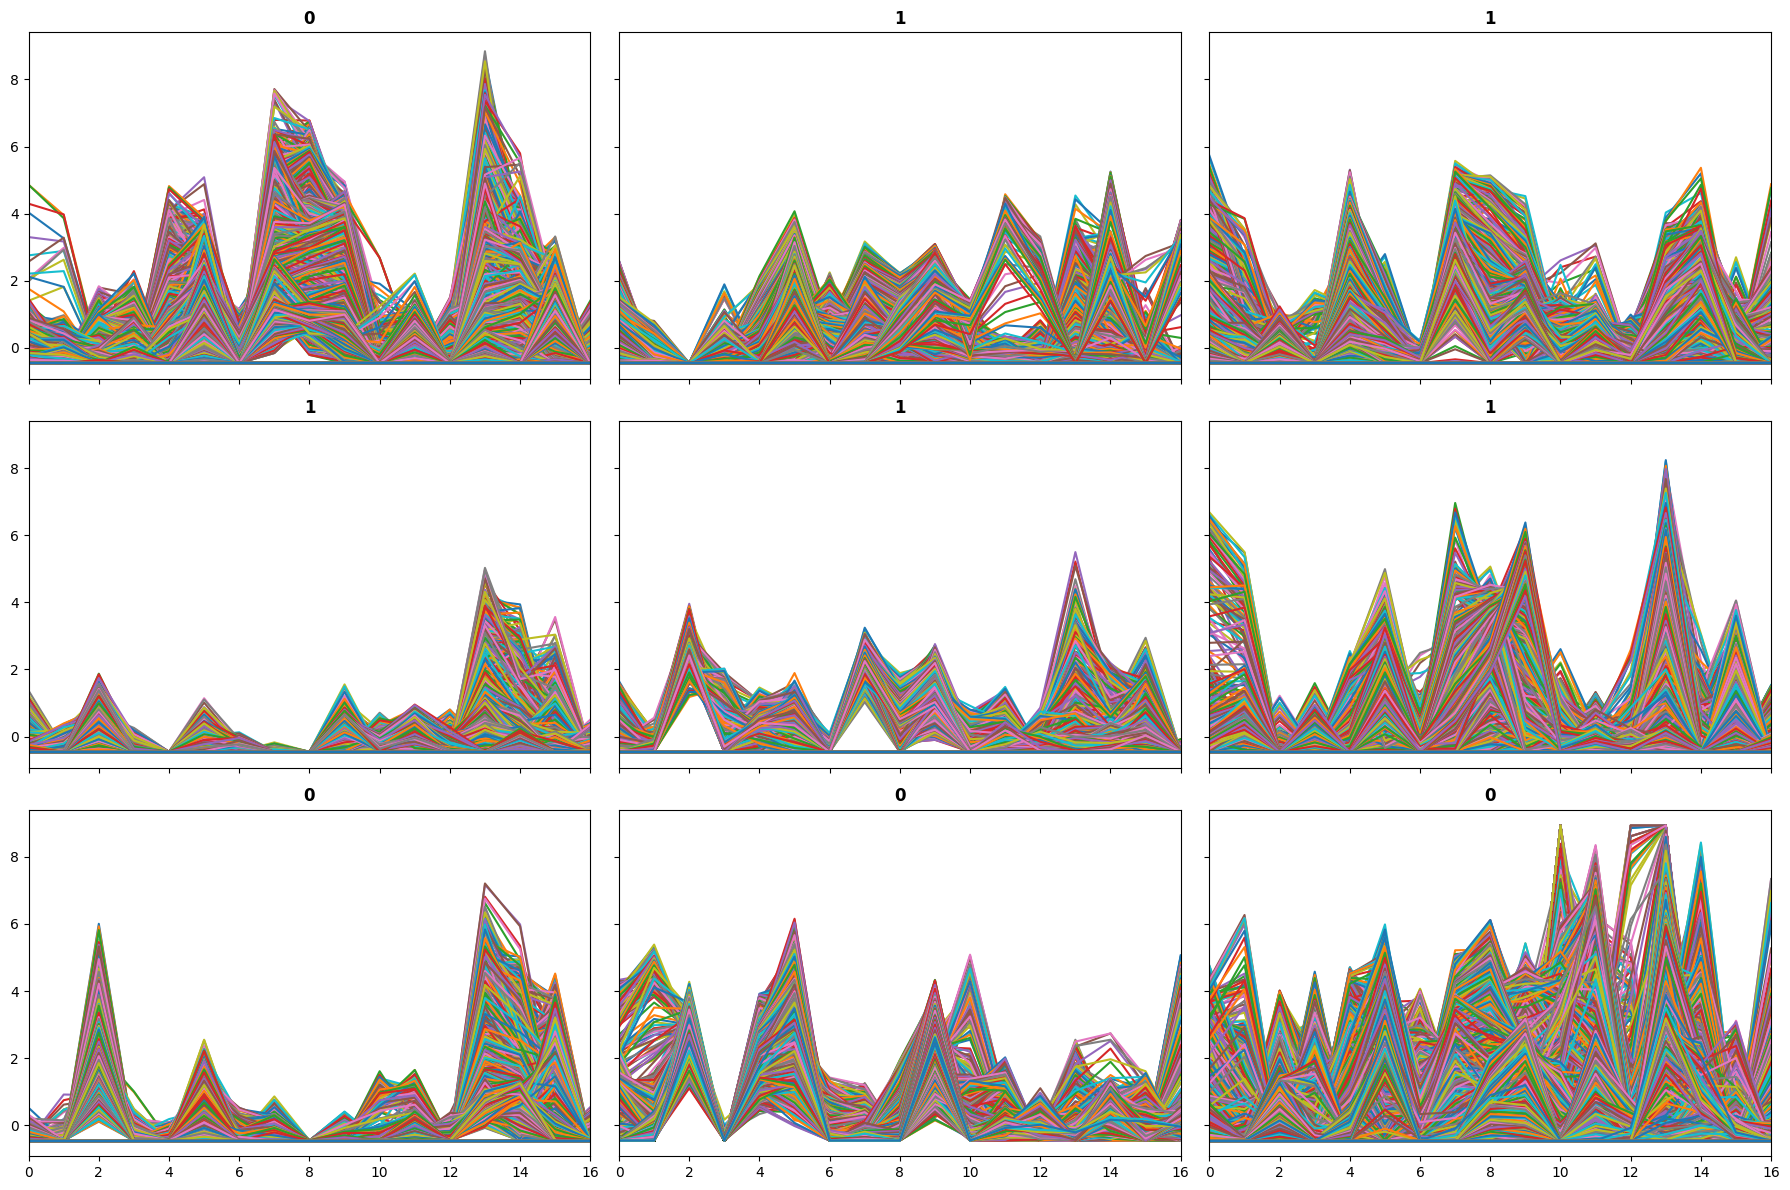

In [39]:
dls.show_batch(sharey=True)

In [40]:
model = InceptionTime(dls.vars, dls.c)
learn = Learner(dls, model, metrics=accuracy)
learn.save('stage0')

Path('models/stage0.pth')

SuggestedLRs(valley=0.0004786300996784121)

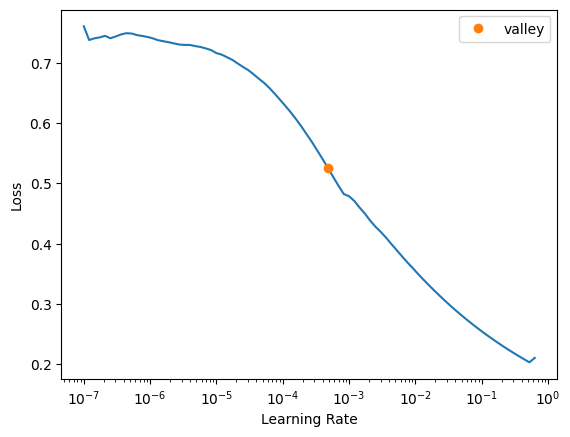

In [41]:
learn.load('stage0')
learn.lr_find()

In [42]:
learn.fit_one_cycle(50, lr_max=1e-3)
learn.save('stage1')

epoch,train_loss,valid_loss,accuracy,time
0,0.739696,0.708091,0.500000,00:00
1,0.705138,0.704945,0.500000,00:00
2,0.667376,0.703515,0.500000,00:00
3,0.628945,0.705475,0.500000,00:00
4,0.597098,0.697092,0.400000,00:00
5,0.552080,0.685443,0.500000,00:00
6,0.516984,0.710976,0.550000,00:00
7,0.479376,0.736743,0.500000,00:00
8,0.447607,0.731193,0.450000,00:00
9,0.413233,0.760021,0.500000,00:00


Path('models/stage1.pth')

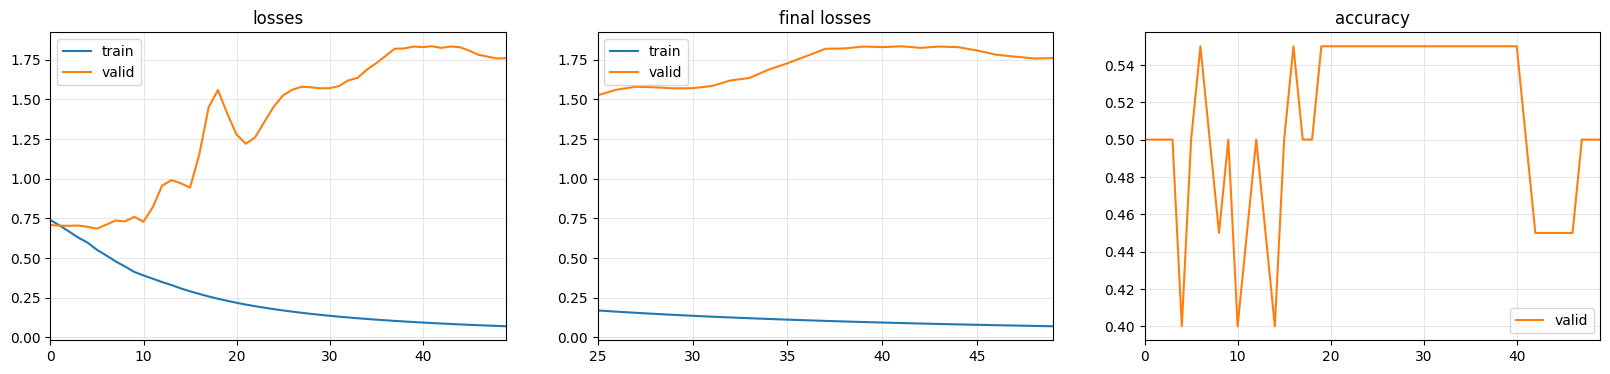

In [43]:
learn.recorder.plot_metrics()

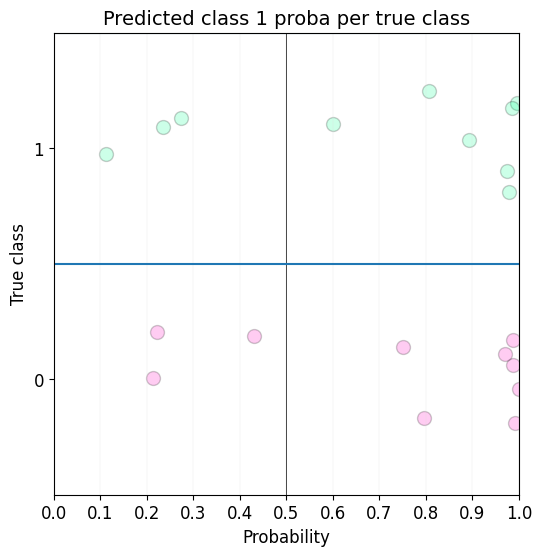

In [44]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls
valid_dl = dls.valid
b = next(iter(valid_dl))
valid_probas, valid_targets, valid_preds = learn.get_preds(dl=valid_dl, with_decoded=True)
learn.show_probas()

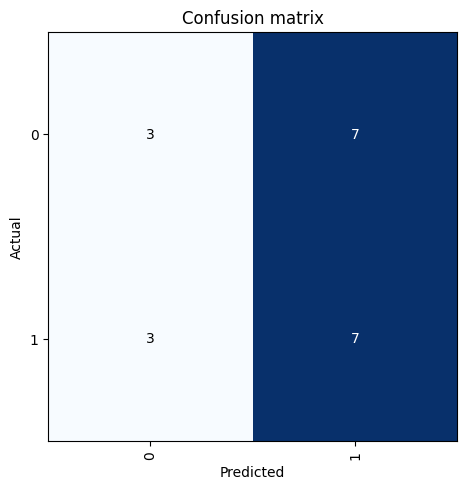

In [45]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()